# 1. Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/back_hospital_new.csv', index_col=0)
data.columns = ['yyyymmdd', 'area', 'sex', 'target']
df_merge = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/merge_data.csv', encoding='cp949')

## 1) 지역명 매핑

In [ ]:
# https://data.kma.go.kr/tmeta/stn/selectStnList.do?pgmNo=123
# 기상관측지점의 주소를 가져와 시도명을 매핑한다. 
area_names = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/META_관측지점정보_20220701105117.csv', index_col=0)
AWS = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw/aws/AWS.csv', encoding='cp949', index_col=0)
new_AWS = pd.merge(AWS, area_names, left_on='지점번호', right_on='지점', how='left')
new_AWS.drop(['지점', '지점명'], axis=1, inplace=True)
idxs = new_AWS['지점주소'].fillna('non fault')
new_AWS['area'] = [idx.split()[0] for idx in idxs]
def area_words(word):
    if word in ['경상북도', '충청북도', '충청남도', '경상남도', '전라북도', '전라남도']:
        word = list(word)[0] + list(word)[2]
    elif word == '서귀포시':
        word = '제주'
    elif word == 'non':
        word = word
    else:
        word = list(word)[0] + list(word)[1]
    return word 
new_AWS['area'] = [area_words(i) for i in new_AWS['area']]
new_AWS.to_csv('/content/drive/MyDrive/ML_projects/weather/new_AWS.csv', index=False, encoding='cp949')

## 남은 100여개는 직접 매핑한다.
new_AWS_after = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/new_AWS_after.csv', encoding='cp949').drop(['관리관서', '지점주소'], axis=1)
new_AWS_after.drop_duplicates(subset = ['지점번호', '지점명(한글)'],ignore_index=True, inplace=True)
new_AWS_after.rename(columns={'지점번호' : 'stn_id'}, inplace=True)

## 2) AWS 병합

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/back_hospital_new.csv', index_col=0)
data.columns = ['yyyymmdd', 'area', 'sex', 'target']
data[data['area'] == '세종']

new_AWS_after = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/new_AWS.csv', encoding='cp949')
new_AWS_after.rename(columns={'지점번호' : 'stn_id'}, inplace=True)
new_AWS_after.drop('지점명(한글)', axis=1, inplace=True)

path = '/content/drive/MyDrive/ML_projects/weather/raw/aws'
file_list = os.listdir(path)
for i in file_list:
     globals()[i.split('.')[0]] = pd.read_csv(f'/content/drive/MyDrive/ML_projects/weather/raw/aws/{i}', encoding='cp949', index_col=0)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, min_value = 0, imputation_order='roman',random_state=42)
func_list = ['mean', 'min', 'max']

# 이상치 제거(기상기후 품질검사 알고리즘 기준) b,e 는 이상치 존재 X 
aws_a_area_2[aws_a_area_2['avg_tca'] < 0] = 0

aws_d_area_2[aws_d_area_2['avg_rhm'] < 0] = 0
aws_d_area_2[aws_d_area_2['min_rhm'] < 0] = 0   
aws_d_area_2[aws_d_area_2['avg_rhm'] > 100] = 100
aws_d_area_2[aws_d_area_2['min_rhm'] > 100] = 100 

aws_g_area_2 = aws_g_area_2.iloc[:, [0,1,2,4,7]]

aws_h_area_2[aws_h_area_2['min_tg'] > 45] = aws_h_area_2['min_tg'].mean()
aws_h_area_2[aws_h_area_2['min_tg'] < -35] = -35
aws_h_area_2[aws_h_area_2['avg_min_tg'] > 45] = aws_h_area_2['avg_min_tg'].mean()
aws_h_area_2[aws_h_area_2['avg_min_tg'] < -35] = -35

aws_i_area_2 = aws_i_area_2.iloc[:,[0,1,2,3,4,8]]

def preprocess_AWS(data):
    # 지역명 매핑 및 날짜변수 변환 
    data = pd.merge(data, new_AWS_after, on='stn_id', how='left')
    data.tma = pd.to_datetime(data.tma)
    data.tma = data.tma.dt.strftime('%Y%m%d')
    data.drop('지점명(한글)', axis=1, inplace=True)

    # 결측치 처리 
    df1 = data.drop(['area'], axis=1)
    df2 = data['area']
    X = pd.DataFrame(imp.fit_transform(df1), columns = data.columns[0:-1])
    X['area'] = df2

    # 시간-지역 별 그룹화 
    cols = X.columns[2:-1].tolist()
    agg_data = X.groupby(['tma','area'])[cols].agg(func_list).reset_index()
    agg_data.columns = list(map('_'.join, agg_data.columns.values))
    agg_data = agg_data.rename(columns={'tma_' : 'yyyymmdd',
                                        'area_' : 'area'})
    
    return agg_data

# 세션 다운 이슈로 하나하나 불러온다 
cloud = preprocess_AWS(aws_a_area_2)
sunshine = preprocess_AWS(aws_b_area_2)
#press = preprocess_AWS(aws_c_area_2)  -> 기압데이터, 결측치가 너무 많다. 70만개 
humidity = preprocess_AWS(aws_d_area_2)
precipitation = preprocess_AWS(aws_e_area_2)
#ground_temp =  preprocess_AWS(aws_f_area_2)  -> 지중온도, 겹치는 데이터고 명확하지 않아 뺐다. 
wind = preprocess_AWS(aws_g_area_2)
protrait_temp = preprocess_AWS(aws_h_area_2)
temp = preprocess_AWS(aws_i_area_2)

# 모든 데이터 합치기 
from functools import reduce
df_list = [cloud, sunshine, humidity, precipitation, wind, protrait_temp, temp]
df_merge = reduce(lambda left, right: pd.merge(left, right, on=['yyyymmdd', 'area'], how='outer'), df_list).drop([31059], axis=0) # 1970년도 데이터가 하나 들어가있어서 삭제해준다. 

# min으로 만든 데이터 중 0이 대부분인 컬럼 삭제
df_merge.drop(['avg_tca_min', 'sum_ss_hr_min', 'ssrate_min'], axis=1, inplace=True)
df_merge.to_csv('/content/drive/MyDrive/ML_projects/weather/merge_data.csv', index=False, encoding='cp949')

## 3) 대기 데이터 

In [6]:
# https://www.airkorea.or.kr/web/last_amb_hour_data?pMENU_NO=123
import math
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, min_value = 0, imputation_order='roman',random_state=42)

path = '/content/drive/MyDrive/ML_projects/weather/raw/atmosphere/'
file_list = os.listdir(path)
func_list = ['mean', 'min', 'max']
data_list = []
for i in tqdm(file_list):
    res = pd.read_csv(path + i)
    data_list.append(res)
    res_data = pd.concat(data_list, axis=0, ignore_index = True)
atmo = res_data.iloc[:, [0,3,4,5,6,7,8]]
df = atmo.copy()  # SettingWithCopyWarning 회피용도 
df.loc[:, 'area'] = [i.split()[0] for i in df['지역']]
df.loc[:, 'yyyymmdd'] = [math.floor(i / 100) for i in df['측정일시']]
df.drop(['지역', '측정일시'], axis=1, inplace=True)

# 이상치 -999를 평균으로 대체
df.loc[df['SO2'] == -999, 'SO2'] = df[df['SO2'] != -999]['SO2'].mean()
df.loc[df['CO'] == -999, 'CO'] = df[df['CO'] != -999]['CO'].mean()
df.loc[df['O3'] == -999, 'O3'] = df[df['O3'] != -999]['O3'].mean()
df.loc[df['NO2'] == -999, 'NO2'] = df[df['NO2'] != -999]['NO2'].mean()
df.loc[df['PM10'] == -999, 'PM10'] = df[df['PM10'] != -999]['PM10'].mean()

# 결측치 대체 
df_1 = df.drop(['area', 'yyyymmdd'], axis=1)
df_2 = df[['area', 'yyyymmdd']]
X = pd.DataFrame(imp.fit_transform(df_1), columns = df.columns[0:-2])
df = pd.concat([X, df_2], axis=1)

# 날짜, 지역별 그룹화 
# 세종 시의 경우 16년도 이후의 데이터만 존재. 
df = df.groupby(['yyyymmdd', 'area'])[['SO2','CO','O3','NO2','PM10']].agg(func_list).reset_index()
df.columns = list(map('_'.join, df.columns.values))
df.rename(columns = {'yyyymmdd_' : 'yyyymmdd', 'area_' : 'area'}, inplace=True)

# 2011년 데이터와 나머지로 분류
df['year'] = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d').dt.year
df_11 = df[df['year'] == 2011]
df_else = df[df['year'] != 2011]

# 데이터 병합 
merged_data = pd.merge(df_merge, df_else, on=['yyyymmdd', 'area'], how='left')
merged_data.drop('year', axis=1, inplace = True)

# 세종시 NaN 데이터 처리 - 날짜별 평균
fill_mean_func = lambda g: g.fillna(g.mean())
for i in merged_data.columns[47:]:
    merged_data[i] = merged_data.groupby('yyyymmdd')[i].apply(fill_mean_func)

merged_data.to_csv('/content/drive/MyDrive/ML_projects/weather/new_merge_data.csv', index=False, encoding='cp949')

,yyyymmdd,area,avg_tca_mean,avg_tca_max,sum_ss_hr_mean,sum_ss_hr_max,ssrate_mean,ssrate_max,avg_rhm_mean,avg_rhm_min,...,CO_max,O3_mean,O3_min,O3_max,NO2_mean,NO2_min,NO2_max,PM10_mean,PM10_min,PM10_max
0,20120101.0,강원,0.718894,5.5,3.888235,48.0,40.902353,505.3,69.453552,45.000000,...,2.7,0.019098,0.002,0.049,0.020873,0.0067,0.0494,81.045044,28.0,193.0
1,20120101.0,경기,1.372896,4.8,1.303226,30.0,13.705645,315.8,71.115826,61.000000,...,2.4,0.012671,0.001,0.041,0.030729,0.0040,0.0830,85.113656,19.0,190.0
2,20120101.0,경남,0.124574,3.3,3.867308,31.5,39.771154,324.7,66.941526,49.000000,...,1.3,0.021270,0.002,0.041,0.017499,0.0006,0.0490,61.998255,12.0,125.0
3,20120101.0,경북,0.266287,6.0,4.221127,48.2,43.850704,502.1,67.295748,52.000000,...,3.1,0.022442,0.001,0.041,0.015240,0.0015,0.0420,72.034221,4.0,243.0
4,20120101.0,광주,1.072693,6.4,0.066667,0.4,0.683333,4.1,78.652086,70.853632,...,1.5,0.014366,0.001,0.037,0.024338,0.0040,0.0500,50.203704,12.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31054,20161231.0,전남,0.000000,0.0,6.436667,53.6,64.963333,541.4,76.628724,54.000000,...,2.9,0.016422,0.001,0.038,0.020574,0.0008,0.0510,32.327484,11.0,116.0
31055,20161231.0,전북,0.161364,5.6,3.250000,26.3,32.920455,265.7,80.435221,70.552857,...,1.6,0.012368,0.001,0.038,0.023351,0.0020,0.0420,47.752429,16.0,106.0
31056,20161231.0,제주,0.000000,0.0,4.652500,44.8,46.525000,448.0,67.404866,37.000000,...,0.5,0.029063,0.003,0.051,0.012552,0.0018,0.0360,24.925220,4.0,73.0
31057,20161231.0,충남,0.000000,0.0,2.670732,30.4,27.256098,310.2,79.276415,69.000000,...,1.8,0.014071,0.001,0.052,0.022291,0.0043,0.0740,42.137500,17.0,86.0


## 4) data에 병합

In [ ]:
from datetime import datetime, timedelta
data.yyyymmdd = [str(i) for i in data['yyyymmdd']]
datetime.strptime(data.yyyymmdd,'%yyyy%mm%dd')
[datetime.strptime(i,'%Y%m%d') for i in data.yyyymmdd]

,yyyymmdd,area,sex,target
1,20120101,강원,1,3
2,20120101,강원,2,3
3,20120101,경기,1,4
4,20120101,경기,2,5
5,20120101,경남,1,2
...,...,...,...,...
49670,20151231,제주,2,0
49671,20151231,충남,1,0
49672,20151231,충남,2,0
49673,20151231,충북,1,1


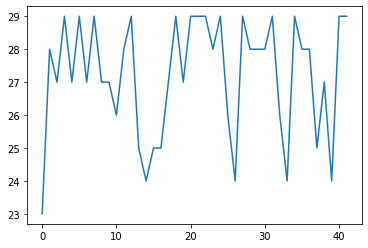

In [ ]:
wow = data.groupby('back_hospital.yyyymmdd')['back_hospital.frequency'].sum()
wow[wow.values > 70]
plt.plot(wow[wow.values < 30].values)